In [ ]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pylab
import statsmodels.api as sm
import statsmodels.stats as smt

In [ ]:
url_lol = 'https://raw.githubusercontent.com/michellyrds/mqaa/master/datasets/high_diamond_ranked_10min.csv'

url = url_lol
raw_data = pd.read_csv(url)

In [ ]:
df = raw_data.filter(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin'])
df.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


# Escalonamento multidimensional

## Objetivo
**Agrupar objetos com base nas suas similaridades.** Para tal, suponha que a base de dados passou por um processo de anotação quanto a percepção da qualidade (assim, a qualidade é uma dimensão subjetiva descrita a partir das váriaveis indicadas abaixo) da equipe azul e vermelha, dado os primeiros 10 minutos da partida do jogo e um "chute" se a equipe azul irá ganhar ou não.

Considere que durante o processo de coleta de dados com os respondentes foram exibidas as váriaveis de composição do time: (`['blueWardsPlaced', 'blueEliteMonsters', 'blueDragons', 'blueHeralds']`) e de desempenho até o momento (10min iniciais): ('`[blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueTowersDestroyed', 'blueTotalMinionsKilled']`), as variáveis equivalentes do time vermelho também foram mostradas, totalizando 22 variáveis.

E as seguintes perguntas foram feitas:
1.   Dado uma nota entre 0 a 10, como você classificaria a experiência da equipe azul em relação à vermelha?
2.   Dado uma nota entre 0 a 10, como você classificaria o desempenho da equipe azul em relação à vermelha?
3.   Você acha que a equipe azul ganhou a partida?

Utilizaremos as variáveis **blueExperienceDiff**, **blueGoldDiff** e **blueWins** como as respostas das perguntas 1, 2 e 3, respectivamente.

Tais variavéis também serão usadas como as medidas gerais de similaridade, supondo que a primeira e segunda estão dentro do intervalo [0, 10] e a terceira é uma variável binária.

Note que:

*blueExperienceDiff = blueTotalExperience - redTotalExperience*  

*blueGoldDiff = blueTotalGold - redTotalGold*  


*TotalExperience* é uma métrica da experiência de todos os jogadores de um respectivo time e *TotalGold* é uma métrica de desempenho de um respectivo time durante uma partida.

In [ ]:
df[['blueExperienceDiff', 'blueGoldDiff', 'blueWins']].describe()

,blueExperienceDiff,blueGoldDiff,blueWins
count,9879.000000,9879.000000,9879.000000
mean,-33.620306,14.414111,0.499038
std,1920.370438,2453.349179,0.500024
min,-9333.000000,-10830.000000,0.000000
25%,-1290.500000,-1585.500000,0.000000
50%,-28.000000,14.000000,0.000000
75%,1212.000000,1596.000000,1.000000
max,8348.000000,11467.000000,1.000000


Aplicando a normalização e re-escala das variáveis *blueExperienceDiff* e *blueGoldDiff*:

In [ ]:
X = raw_data.filter(['blueExperienceDiff', 'blueGoldDiff', 'blueWins'])

X = (X - X.min())/(X.max()-X.min())*10
X['blueWins'] = raw_data['blueWins']
X.describe()

,blueExperienceDiff,blueGoldDiff,blueWins
count,9879.000000,9879.000000,9879.000000
mean,5.259533,4.863620,0.499038
std,1.086121,1.100305,0.500024
min,0.000000,0.000000,0.000000
25%,4.548668,4.146073,0.000000
50%,5.262711,4.863435,0.000000
75%,5.964029,5.572947,1.000000
max,10.000000,10.000000,1.000000


## Criando o mapa perceptual

Por ser tratar de uma técnica com elevado custo computacional, utilizaremos uma amostra de 10% do dataframe.

In [ ]:
X = X.sample(frac=0.1).to_numpy()
print('Tamanho da amostra: {}'.format(len(X)))

Tamanho da amostra: 988


In [ ]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import seaborn as sns         
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

\Para criar o mapa perceptual, utilizaremos a distância euclidiana como medida de similaridade e o algoritmo *stress minimization using majorization* (SMACOF) para aplicar o escalonamento multidimensional. Faremos a redução de dimensionalidade para 3 dimensões.  
Para essa aplicação, estamos considerando o método métrico (entrada e saída dos dados serão valores métricos).

In [ ]:
dist_euclidean = euclidean_distances(X)
mds = MDS(dissimilarity='precomputed', random_state=0,n_components=3)
X_transform = mds.fit_transform(dist_euclidean)

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(X_transform)

[[-1.25186249e-01 -2.95863767e-01  4.34518962e-01]
 [-6.13833303e-01 -4.61594480e-01 -1.04388053e+00]
 [ 8.01445143e-01 -8.49271024e-02 -2.12799645e-01]
 [-1.49805829e+00 -1.77353096e-01 -1.82272831e-01]
 [ 1.98074747e+00 -1.77441195e-02  3.82331422e-01]
 [-3.58206536e-01  9.08502234e-02  4.73230708e-01]
 [ 2.08626776e+00 -2.47924247e-02  4.30426526e-01]
 [-1.62542592e+00 -1.76955987e-01 -2.43612760e-01]
 [-2.61201232e-01  5.38943406e-01 -4.80643586e-01]
 [ 1.54886009e+00  3.03364177e-02  1.92779484e-01]
 [ 2.43523059e-01  2.49202537e-01 -3.51257586e-01]
 [ 6.89567478e-01  1.29683902e-01 -1.82952944e-01]
 [ 2.35618649e+00  1.02419005e-01  6.09688922e-01]
 [ 1.76723357e+00 -4.32307621e-01  1.18694194e-01]
 [-1.07846820e+00 -2.63905411e-01 -1.35909918e-02]
 [-8.18319276e-01  2.94023759e-01  3.30673200e-01]
 [-1.40114660e+00  3.32013042e-02 -5.29910217e-02]
 [-1.65679775e-01  6.20414809e-02 -6.22178413e-01]
 [ 1.58080246e-03 -2.12821612e-01  5.28198246e-01]
 [-2.13889361e+00 -2.68626274e-

Plotando os gráficos de dispersão do modelo resultante:

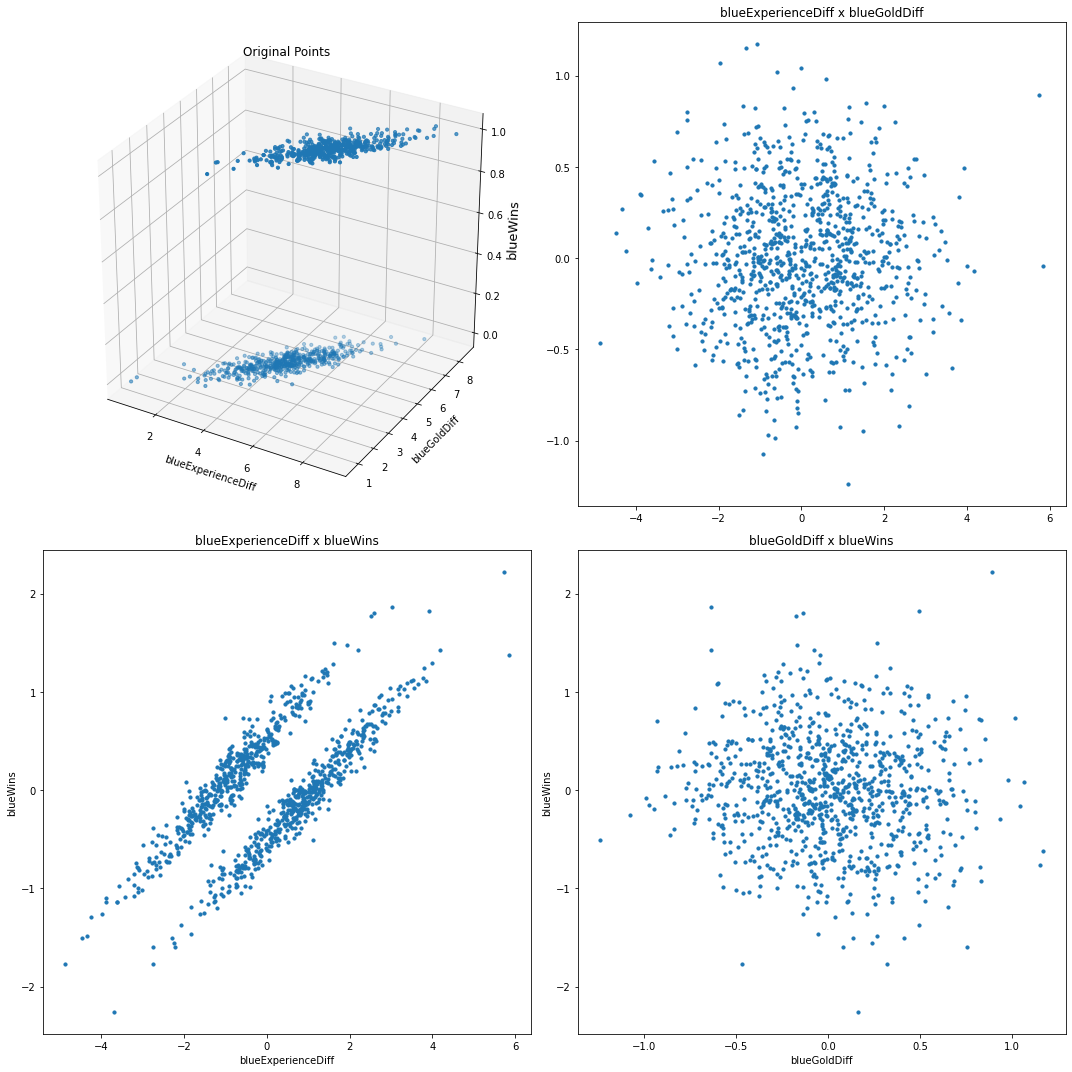

In [ ]:
size = 10
fig = plt.figure(4, (15,15))
ax = fig.add_subplot(221, projection='3d')
plt.scatter(X[:,0], X[:,1], zs=X[:,2], s=size)
plt.xlabel("blueExperienceDiff")
plt.ylabel("blueGoldDiff")
ax.set_zlabel('blueWins', fontsize=13, rotation=60)
plt.title('Original Points')

ax = fig.add_subplot(222)
plt.scatter(X_transform[:,0], X_transform[:,1], s=size)
#plt.scatter(X[:,0], X[:,1], s=size)
plt.title('blueExperienceDiff x blueGoldDiff')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(223)
plt.scatter(X_transform[:,0], X_transform[:,2], s=size)
#plt.scatter(X[:,0], X[:,2], s=size)
plt.title('blueExperienceDiff x blueWins')
plt.xlabel("blueExperienceDiff")
plt.ylabel("blueWins")
fig.subplots_adjust(wspace=.4, hspace=0.5)


ax = fig.add_subplot(224)
plt.scatter(X_transform[:,1], X_transform[:,2], s=size)
#plt.scatter(X[:,1], X[:,2], s=size)
plt.title('blueGoldDiff x blueWins')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.xlabel("blueGoldDiff")
plt.ylabel("blueWins")
plt.tight_layout()
plt.show()

## Interpretação dos resultados

Podemos observar que ao decorrer de nossa análise, a nossa amostra utilizada demonstra que os resultados que possuem o valor blueWins igual a 1, ou seja, vitória do time azul levando em conta os dados até os 10 minutos de jogo, possuem em média uma diferença positiva de ouro (blueGoldDiff) e experiência (blueExpDiff). Em outras palavras, o conjunto de jogos que estão com a vitória do time azul estão mais deslocados para o quadrante que possui vantagem em ouro e vantagem em experiência quando são comparados o ouro e experiência de ambos times aos 10 minutos de jogo.

## Conclusão

Com o escalonamento multidimensional, conseguimos deixar bem evidente que variáveis da nossa amostra impactam em que.
Desse modo, conseguimos perceber que o ouro(blueGoldDiff) e a esperiência(blueExpDiff) são ótimas medidas para predizer quem provavelmente irá ganhar o jogo

## Referências
Slides de aula: **Escalonamento Mutidimensional I e II**.  
ACH2036 – Métodos Quantitativos Aplicados à Adm. de Empresas I  
Prof. Regis Rossi A. Faria

---
**Análise multivariada de dados**. Por Joseph F. Hair, William C. Black, Barry J. Babin, Rolph E. Anderson, Ronald L. Tatham.

---

**Guide to Multidimensional Scaling in Python with Scikit-Learn**. Por Mehreen Saeed. Disponível em: https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/.
